<a href="https://colab.research.google.com/github/JonatanPolanco/CIG_Da1_Project/blob/main/Monthly_Automated_DA1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Vehicles Productivity analysis by month** - Jonatan Polanco (CIG Intern)

In [1]:
#importing libraries

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd  
import plotly.express as px   #para los mapas
import seaborn as sns
from numpy import array
from datetime import datetime as dt, date

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import files
from google.colab import drive

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

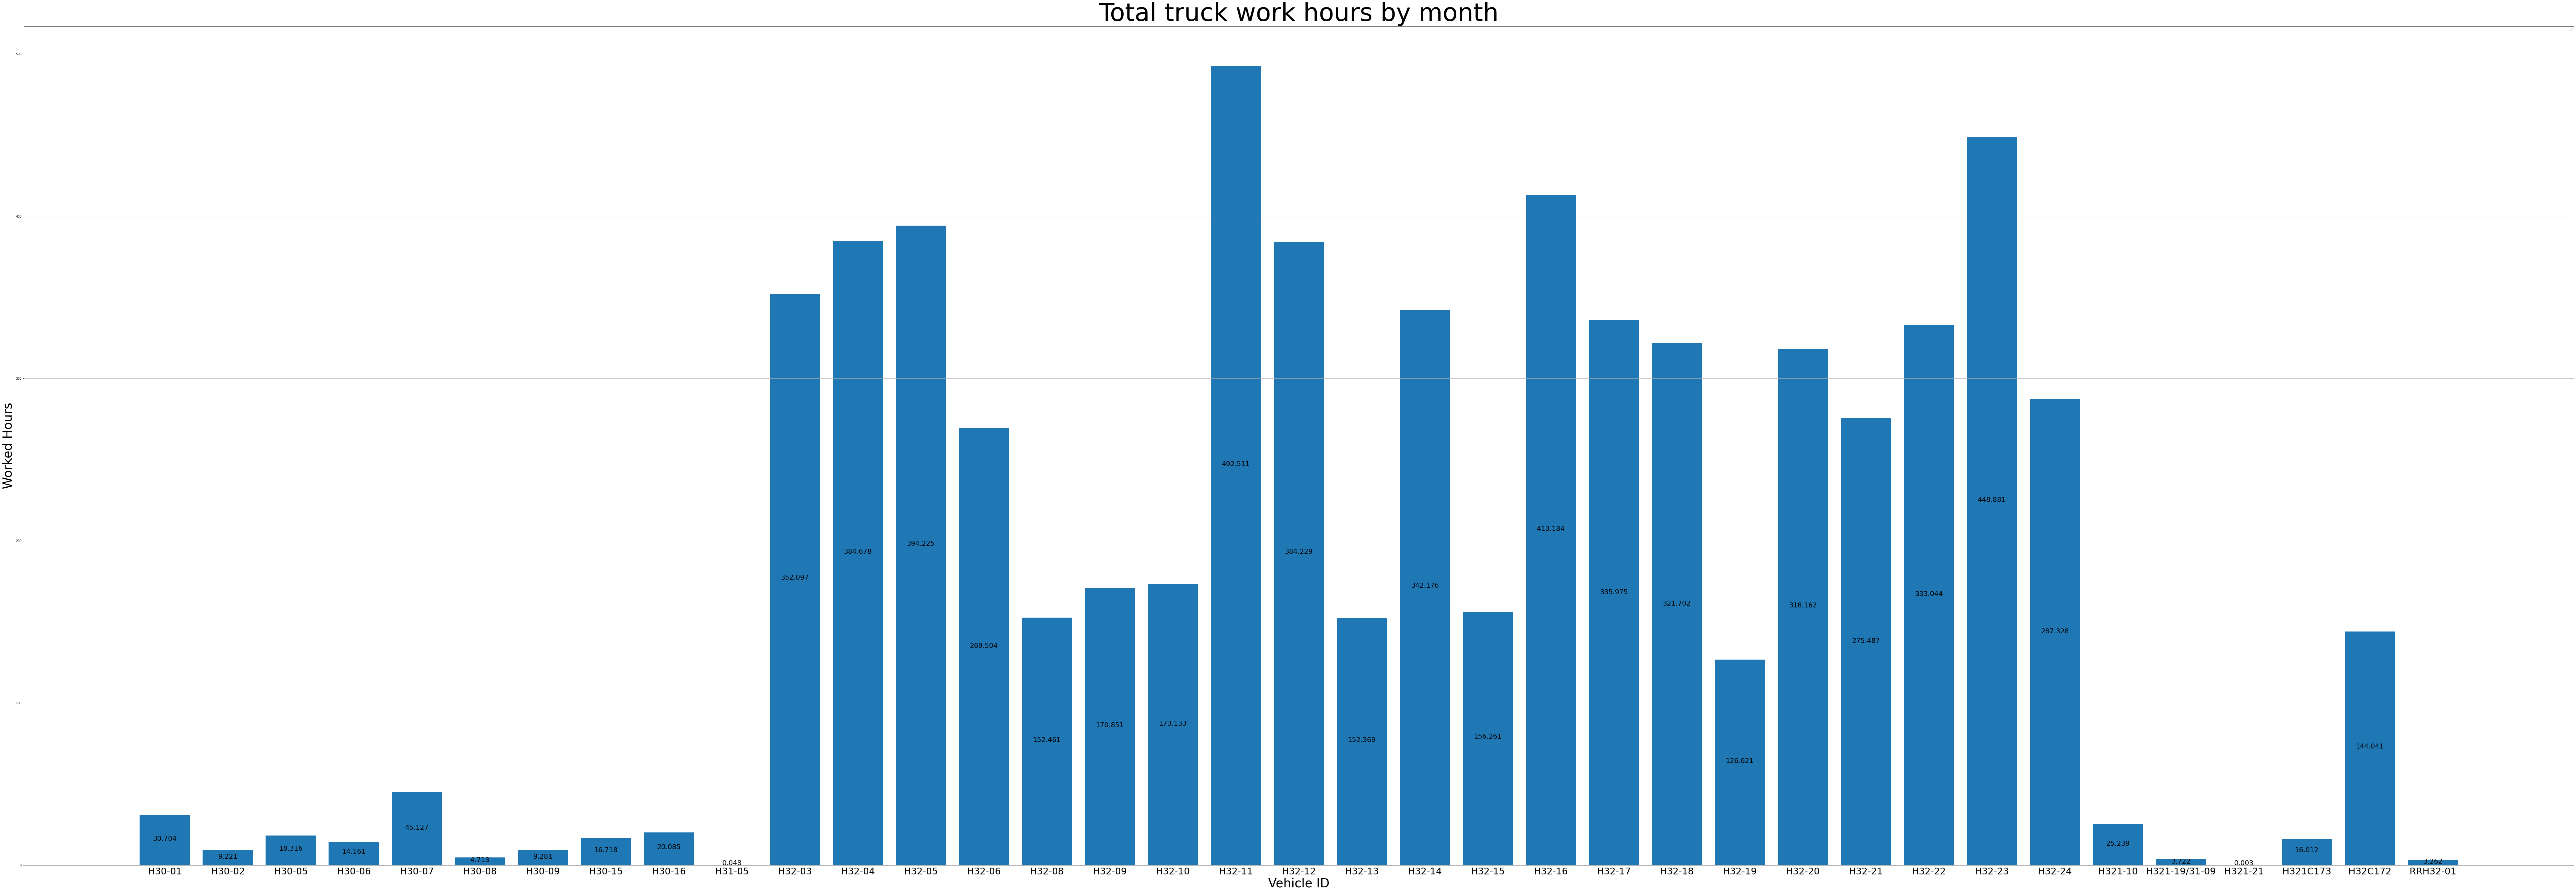

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

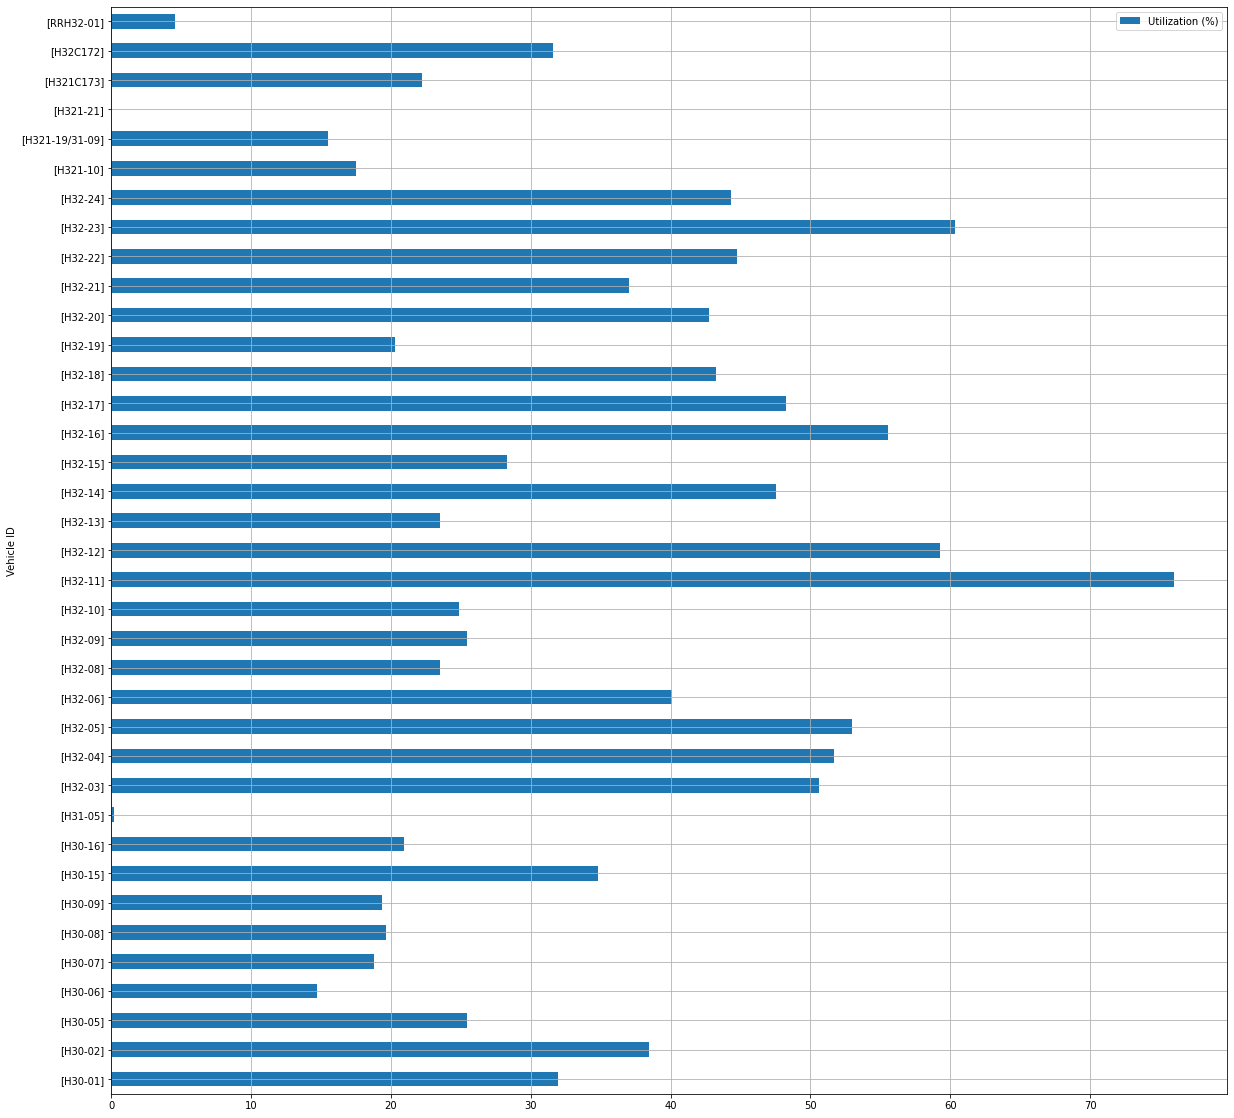

In [26]:
#Load data

#file = 'detailed_report_by_driver_2.xlsx'   
#df = pd.read_excel(file)

#Data pre-processing

#df = df.drop(range(2))
#df = df.drop(['Driver Name'], axis=1)
#df = df.drop(['Shut Down'], axis=1)
#df = df.reset_index().drop(['index'], axis=1)
#df = df.dropna()

file = 'edited_detailed_report_by_driver.xlsx'    #This database file was edited because the date field doesn't have the same format
df = pd.read_excel(file)

#df=df.drop(['Unnamed: 0'], axis=1)

if 'TRACK(hour)' in df.columns and 'HYDR(hour)' in df.columns and 'SEAT(hour)' in df.columns:

  #Data pre-processing

  df['Date'] = pd.to_datetime(df['Date'])
  df['Date'] = df['Date'].dt.strftime("%d-%m-%Y")
  df = df.rename(columns={'SEAT(hour)': 'SEAT'})
  df = df.rename(columns={'HYDR(hour)': 'HYDR'})
  df = df.rename(columns={'TRACK(hour)': 'TRACK'})
  df['Duration'] = pd.to_timedelta(df['Duration'].astype(str))
  df['SEAT'] = pd.to_timedelta(df['SEAT'].astype(str))
  df['HYDR'] = pd.to_timedelta(df['HYDR'].astype(str))
  df['TRACK'] = pd.to_timedelta(df['TRACK'].astype(str))
  
  id = df['Vehicle ID']
  vehicles = id.drop_duplicates()
  vehicles = vehicles.reset_index().drop(['index'], axis=1)
  N_Vehicles = len(vehicles)
  #print(vehicles,N_Vehicles )
  X = [None] * N_Vehicles
  X_ = {}   
  Day = [None] * N_Vehicles
  productivity = [None] * N_Vehicles
  required_hours = 24       # Working hours required by the company

  ###### Data Flowchart ############
#---------------------------------------------------------------------------------------------------------------------------------------
## First case (We have HYDR and TRACK data)

  if (df['TRACK'].sum().days+df['TRACK'].sum().seconds/86400)*24 != 0:      # ask by tracktion data
    if (df['HYDR'].sum().days+df['HYDR'].sum().seconds/86400)*24 != 0:      # ask by hydraulic data

      #Productivity analysis by truck (Monthly)

      #Get total hours by vehicle
      for i in range(N_Vehicles):

        X_[i] = df[df['Vehicle ID'] == vehicles['Vehicle ID'].iloc[i]]  #Creates a Dataframe by vehicle
        Day[i] = len(X_[i]['Date'].drop_duplicates())  #Get the work day's by vehicle
        track = df[df['Vehicle ID'] == vehicles['Vehicle ID'].iloc[i]].TRACK.sum()  #Traction duration
        hydr = df[df['Vehicle ID'] == vehicles['Vehicle ID'].iloc[i]].HYDR.sum()  #Hydraulics duration
        seat = df[df['Vehicle ID'] == vehicles['Vehicle ID'].iloc[i]].SEAT.sum()  #Seat duration
        
        #Get productivity with the maximum value (HYDR VS TRACK)
        if track >= hydr:
          P_hours = ((track.days + track.seconds/86400)*24)   #Get pruductive hours
          seat = ((seat.days + seat.seconds/86400)*24)    # To hours
          X[i] = seat - (seat - P_hours)                    #Get utilization 
          X[i] = round(X[i], 3)
          productivity[i] = (X[i]/(Day[i]*required_hours))*100  #Monthly productivity calculation
          productivity[i] = round(productivity[i], 2)

        else:
          P_hours = ((hydr.days + hydr.seconds/86400)*24)   #Get pruductive hours
          seat = ((seat.days + seat.seconds/86400)*24)    # To hours
          X[i] = seat - (seat - P_hours)                    #Get utilization 
          X[i] = round(X[i], 3)
          productivity[i] = (X[i]/(Day[i]*required_hours))*100  #Monthly productivity calculation
          productivity[i] = round(productivity[i], 2)
      
    #-------------------------------------------------------------------------------------------------------
    # Second case we have only TRACK data
    else:
      for i in range(N_Vehicles):

        X_[i] = df[df['Vehicle ID'] == vehicles['Vehicle ID'].iloc[i]]  #Creates a Dataframe by vehicle
        Day[i] = len(X_[i]['Date'].drop_duplicates())  #Get the work day's by vehicle
        track = df[df['Vehicle ID'] == vehicles['Vehicle ID'].iloc[i]].TRACK.sum()  #Traction duration
        hydr = df[df['Vehicle ID'] == vehicles['Vehicle ID'].iloc[i]].HYDR.sum()  #Hydraulics duration
        seat = df[df['Vehicle ID'] == vehicles['Vehicle ID'].iloc[i]].SEAT.sum()  #Seat duration

        P_hours = ((track.days + track.seconds/86400)*24)   #Get pruductive hours
        seat = ((seat.days + seat.seconds/86400)*24)    # To hours
        X[i] = seat - (seat - P_hours)                    #Get utilization 
        X[i] = round(X[i], 3)
        productivity[i] = (X[i]/(Day[i]*required_hours))*100  #Monthly productivity calculation
        productivity[i] = round(productivity[i], 2)


#---------------------------------------------------------------------------------------------------------------------------------
### Third case (We only have HYDR data)

  elif (df['HYDR'].sum().days+df['HYDR'].sum().seconds/86400)*24 != 0:
    for i in range(N_Vehicles):

        X_[i] = df[df['Vehicle ID'] == vehicles['Vehicle ID'].iloc[i]]  #Creates a Dataframe by vehicle
        Day[i] = len(X_[i]['Date'].drop_duplicates())  #Get the work day's by vehicle
        hydr = df[df['Vehicle ID'] == vehicles['Vehicle ID'].iloc[i]].HYDR.sum()  #Hydraulics duration
        seat = df[df['Vehicle ID'] == vehicles['Vehicle ID'].iloc[i]].SEAT.sum()  #Seat duration

        P_hours = ((hydr.days + hydr.seconds/86400)*24)   #Get pruductive hours
        seat = ((seat.days + seat.seconds/86400)*24)    # To hours
        X[i] = seat - (seat - P_hours)                    #Get utilization 
        X[i] = round(X[i], 3)
        productivity[i] = (X[i]/(Day[i]*required_hours))*100  #Monthly productivity calculation
        productivity[i] = round(productivity[i], 2)

  #----------------------------------------------------------------------------------------------------------------------
  # Fourth Case we only have SEAT data or Session

  else: 
    for i in range(N_Vehicles):

        X[i] = df[df['Vehicle ID'] == vehicles['Vehicle ID'].iloc[i]].SEAT.sum()  #Truck SEAT duration sum
        X_[i] = df[df['Vehicle ID'] == vehicles['Vehicle ID'].iloc[i]]  #Creates a Dataframe by vehicle
        Day[i] = len(X_[i]['Date'].drop_duplicates())  #Get the work day's by vehicle

        X[i] = (X[i].days + X[i].seconds/86400)*24   #Set to hours
        X[i] = round(X[i], 3)
        productivity[i] = (X[i]/(Day[i]*required_hours))*100  #Monthly productivity calculation
        productivity[i] = round(productivity[i], 2)


vehicles = np.array(vehicles, dtype=str)

#Utilization table ------------------------------------------------------------------------------------------------
#for i in range(N_Vehicles):
  #print(vehicles[i])
  #print(X[i], 'hours')
  #print(Day[i], 'days')
  #print('-----------------')


productivity_M = pd.DataFrame((X, Day, productivity, vehicles)).T   
productivity_M = productivity_M.rename(columns={3: 'Vehicle ID', 0: 'Hours', 1: 'Days', 2: 'Utilization (%)'})
productivity_M = productivity_M.reindex(columns= ['Vehicle ID', 'Hours', 'Days', 'Utilization (%)'])
productivity_M = productivity_M.sort_values(by = 'Vehicle ID')
productivity_M = productivity_M.reset_index().drop(['index'], axis=1)

#To download utilization data table by month (uncomment line 165)

productivity_M.to_excel("Monthly_Vehicle_Productivity.xlsx")
files.download('Monthly_Vehicle_Productivity.xlsx')
productivity_M


# Worked hours bar plot -----------------------------------------------------------------------------------------
def addlabels(x,y):
    for i in range(len(y)):
        plt.text(i, y[i]//2, y[i], ha = 'center', fontsize=22)

y= np.concatenate(productivity_M['Vehicle ID'])
x = productivity_M['Hours']

fig, ax = plt.subplots()
fig.set_size_inches(N_Vehicles*4, 50)
ax.set_ylabel('Worked Hours', fontsize=40)
ax.set_xlabel('Vehicle ID', fontsize=40)
ax.set_title('Total truck work hours by month', fontsize=80)
ax.legend()

addlabels(y, x)

plt.bar(y, x)
plt.xticks(y, x)
ax.set_xticklabels(y, fontsize=30)
plt.grid(True)
plt.savefig('Monthly_Vehicle_Hours.png', bbox_inches='tight')
files.download('Monthly_Vehicle_Hours.png')
plt.show()

#Utilization bar plot ---------------------------------------------------------------------------
productivity_M.plot(kind='barh', x= 'Vehicle ID', y= 'Utilization (%)', figsize=(20,20))
plt.grid(True)
plt.savefig('Monthly_Vehicles_Utilization.png')
files.download('Monthly_Vehicles_Utilization.png')
#plt.show()




#Bar plot by productivity
